## repeataly

**predicting repeat customers with sales data**

zen yui | 2016-03-05

### notes:
- k-means to segment
- logistic regression for feature selection
- random forest for prediction

In [613]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
%matplotlib inline

In [614]:
from datetime import date, timedelta
from calendar import monthrange

In [615]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, ShuffleSplit

In [616]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [815]:
from sklearn.ensemble import RandomForestClassifier

In [826]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [617]:
# use ggplot style
plt.style.use('ggplot')

### read data from source csv

In [618]:
# read data in from csv
df_read = pd.read_csv('eataly_data.csv')

In [619]:
# copy dataframe so we don't edit original file data
df = df_read.copy()

### data munging and feature engineering in pandas

In [620]:
# drop customer visit and visit key, as it cannot be used for analysis
df.drop(['CustomerKey','VisitNumber'], axis=1, inplace=True)

In [621]:
# convert TicketDate to datetime type
df['TicketDate'] = pd.to_datetime(df['TicketDate'])

In [622]:
# get integer month of ticket
# df['TicketMonth'] = df['TicketDate'].apply(lambda x: x.month)

In [623]:
# get months with decimals for days
def get_mth_dec(d):
    """Given a date, return integer month and decimal days"""
    return d.month + d.day / (monthrange(d.year,d.month)[1] + 1)

df['TicketMonthDecimal'] = df['TicketDate'].apply(get_mth_dec)

In [624]:
#get weekday number (1=Monday ... 7=Sunday)
df['WeekdayNumber'] = df['TicketDate'].apply(lambda x: x.isoweekday())

In [625]:
# Binary flag for a weekday visit
# df['IsWeekday'] = df['WeekdayNumber'] < 6

In [626]:
#convert 'TicketTime' to continuous integer
TimeList = df['TicketTime'].str.split(':')
df['TicketTime'] = TimeList.str[0].astype(float) + TimeList.str[1].astype(float) / 60.0

In [627]:
#create "isFrontEnd" feature, drop 'StationGroup'
df['IsFrontEnd'] = df['StationGroup'] == 'Front End'
df.drop('StationGroup',axis=1,inplace=True)

In [628]:
# drop TicketDate, as we want trends across seasons not years
df.drop('TicketDate', axis=1, inplace=True)

In [629]:
# make prediction right-most column
df = pd.concat([df.drop('WillReturn', axis=1), df['WillReturn']], axis=1)

In [630]:
df.shape

(1621854, 17)

In [631]:
# sample data, transposed for readability
df.sample(7).T

,7687,1533671,192964,1466582,1199583,1333294,267013
TicketTime,12.2,11.4667,15.4833,17.0333,18.3833,17.15,14.1
PriorVisits,0,0,12,4,10,0,0
SaleLines,2,1,4,1,2,4,1
ReturnLines,0,0,0,0,1,0,0
GiftCardLines,0,0,0,0,0,0,0
NetAmount,7.6,5.8,13.08,7.6,19.89,17.2,9
NetRetailAmount,0,0,13.08,0,19.94,17.2,0
NetQSRAmount,7.6,5.8,0,7.6,0,0,9
DiscountAmount,0,0,0,0,0,0,0
UniqueItems,1,1,4,1,3,2,1


In [632]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TicketTime,1.62185e+06,16.3297,3.10457,0,13.7333,16.2333,18.7667,23.9667
PriorVisits,1.62185e+06,5.23733,18.046,0,0,1,3,564
SaleLines,1.62185e+06,3.75782,4.26383,0,1,2,5,166
ReturnLines,1.62185e+06,0.0172482,0.149757,0,0,0,0,24
GiftCardLines,1.62185e+06,0.00170484,0.0792194,0,0,0,0,55
NetAmount,1.62185e+06,29.8887,42.4892,-966.4,8.64,15.98,35.2,6793.92
NetRetailAmount,1.62185e+06,25.0018,42.8552,-966.4,0,10.43,32.4,4738
NetQSRAmount,1.62185e+06,4.82743,9.41026,-116.6,0,0,8.08,1036.37
DiscountAmount,1.62185e+06,0.075909,1.45071,-241.6,0,0,0,388.79
UniqueItems,1.62185e+06,3.55048,3.8821,1,1,2,4,93


In [633]:
df.dtypes

TicketTime            float64
PriorVisits             int64
SaleLines               int64
ReturnLines             int64
GiftCardLines           int64
NetAmount             float64
NetRetailAmount       float64
NetQSRAmount          float64
DiscountAmount        float64
UniqueItems             int64
UniqueCategories        int64
ReturnedBags             bool
BoughtProduce            bool
TicketMonthDecimal    float64
WeekdayNumber           int64
IsFrontEnd               bool
WillReturn               bool
dtype: object

### get the overall rate repeat visits

In [634]:
'Overall tickets yielding repeat business: {:.2f}%'.format(df.WillReturn.mean()*100)

'Overall tickets yielding repeat business: 44.46%'

### dealing with outliers
- Some data is clearly wrong or unhelpful (like sales when we are closed)
- Other outliers exist, but they cannot be removed yet as they often indicate loyal customers (high rollers)

In [635]:
# remove sales before 7am and after 11pm
df = df[(df['TicketTime'] >= 7) & (df['TicketTime'] <= 23.5)]

### EDA on features

### define two EDA helper functions

In [639]:
# define function 'get_rrate' for quick analysis of features and repeat business
def get_rrate(df, col_list):
    """Given a dataframe and list of groupby columns,
    return a crosstab dataframe of Repeat, NonRepeat, and RepeatRate
    """
    rdict = {1:'Repeat',0:'NonRepeat'}
    rorder = ['Repeat','NonRepeat']

    ct = pd.crosstab([df[c] for c in col_list], df['WillReturn'].map(rdict))[rorder]
    ct['CustCount'] = ct['Repeat'] + ct['NonRepeat']
    ct['CustDist'] = ct['CustCount'].astype(float) / ct['CustCount'].sum() * 100
    ct['RepeatRate'] = ct['Repeat'].astype(float) / ct['CustCount'] * 100
    ct['RepeatDist'] = ct['Repeat'].astype(float) / ct['Repeat'].sum() * 100
    ct.columns.name=None
    return ct

In [640]:
def plot_rrate(df, col_list):
    """Given dataframe and list of columns, call "get_rrate" to
    calculate return-rate distributions by feature values,
    then plot the rate of return and % return rate
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ct = get_rrate(df, col_list)
    ct[['Repeat','NonRepeat']].plot(kind='bar', stacked=True, color=['g','k'], alpha=.5, ax=axes[0])
    axes[0].set_title('returns per ' + ', '.join(col_list))
    axes[0].set_ylabel('Customer Count')
    
    ct[['RepeatRate']].plot(kind='bar', stacked=True, color=['blue'], alpha=.5, ax=axes[1], ylim=(0,100))
    axes[1].set_title('return rate by ' + ', '.join(col_list))
    axes[1].set_ylabel('% Return Rate')

In [641]:
def plot_rrate_hist(df, cut_col, bins):
    """Give dataframe and a "cut_col" feature name, 
    cut the continuous feature values into "bins" 
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    
    dgrp = df.groupby(pd.cut(df[cut_col], bins))['WillReturn']
    
    dgrp1 = pd.concat([dgrp.sum(), dgrp.count() - dgrp.sum()], axis=1)
    dgrp1.columns = ['Repeat','NonRepeat']
    dgrp1.plot(kind='bar', stacked=True, color=['g','k'], alpha=.5, title=cut_col + ' distribution', ax=axes[0])
    axes[0].set_title(cut_col + ' distribution')
    axes[0].set_ylabel('Customer Count')
    
    
    (dgrp.mean()*100).plot(kind='bar', color='blue',alpha=.5,ax=axes[1], title='return rate by ' + cut_col, ylim=(0,100))
    axes[1].set_title('return rate by ' + cut_col)
    axes[1].set_ylabel('% Return Rate')

### impact of weekdays on return visits
- Traffic seems equally distributed between days of the week
- More repeat customers shop on weekdays in number and on a percentage basis

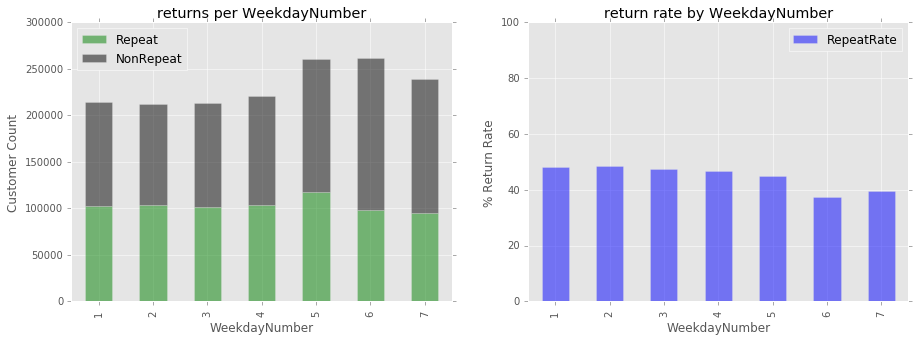

In [642]:
plot_rrate(df, ['WeekdayNumber'])

### impact of seasonality on repeat business
- Sales seem normally distributed across months
- Return rate is steady across months (slightly higher in January)

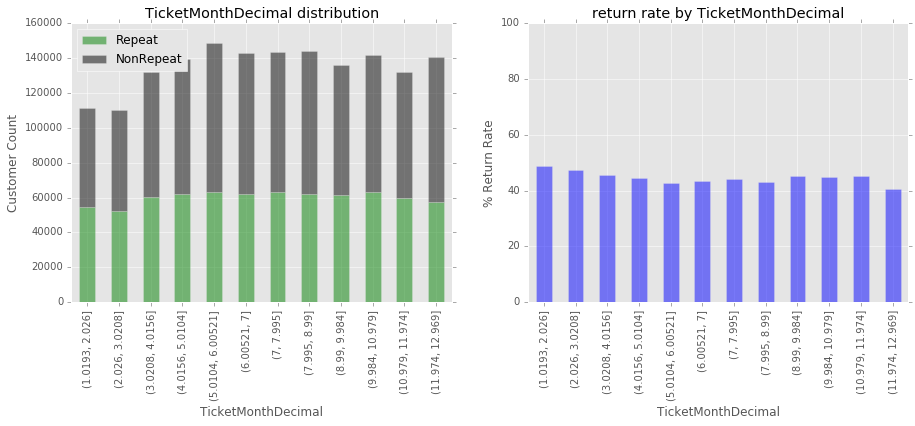

In [643]:
plot_rrate_hist(df, 'TicketMonthDecimal', 12)

### time of day VS repeat business
- of course, sales are focussed around 12PM - 7PM, with outliers on either end
- repeat business is slightly more likely between 9AM-11AM and at 6PM

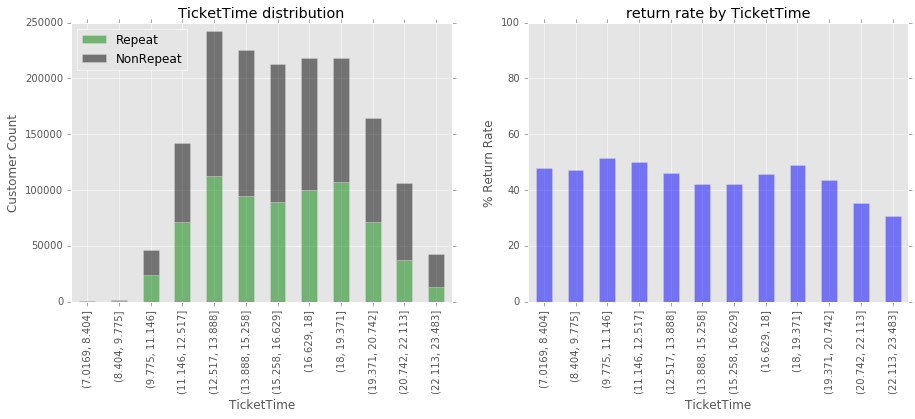

In [644]:
plot_rrate_hist(df, 'TicketTime', 12)

### produce shopping VS repeat business
- Feature 'BoughtProduce' comes from domain knowledge about customer behavior
- Produce shopping must be done locally (natural filter for tourists)
- Fresh produce is uniquely "Italian"... maybe these shoppers use Eataly as a grocery store

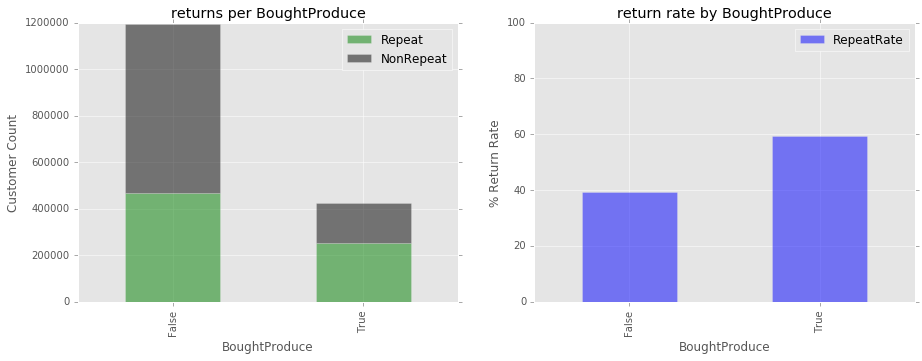

In [645]:
plot_rrate(df, ['BoughtProduce'])

### returning bags VS repeat business
- Another feature from domain knowledge
- Eataly refunds customers $0.05 for returning shopping bags
- This would definintely suggest prior visits on by the customer
- Far more customers do no return bags (98%), so feature may not work

In [646]:
get_rrate(df, ['ReturnedBags'])

,Repeat,NonRepeat,CustCount,CustDist,RepeatRate,RepeatDist
ReturnedBags,,,,,,
False,710691,893775,1604466,98.930456,44.294550,98.554461
True,10424,6922,17346,1.069544,60.094546,1.445539


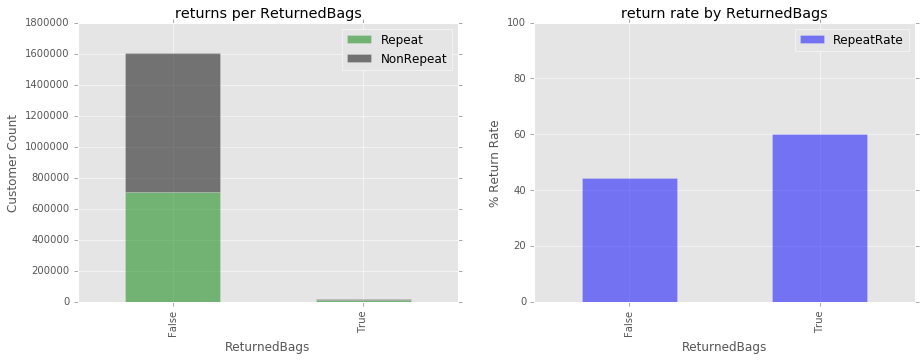

In [647]:
plot_rrate(df, ['ReturnedBags'])

### Net spend vs repeat business
- First pair of graphs show spending distributions from 25th - 75th percentiles
- Second pair of graphs show spending distributions from \$0 - $250
- Both pairs suggest natural tendancy towards smaller dollar value tickets, but constant probability of return

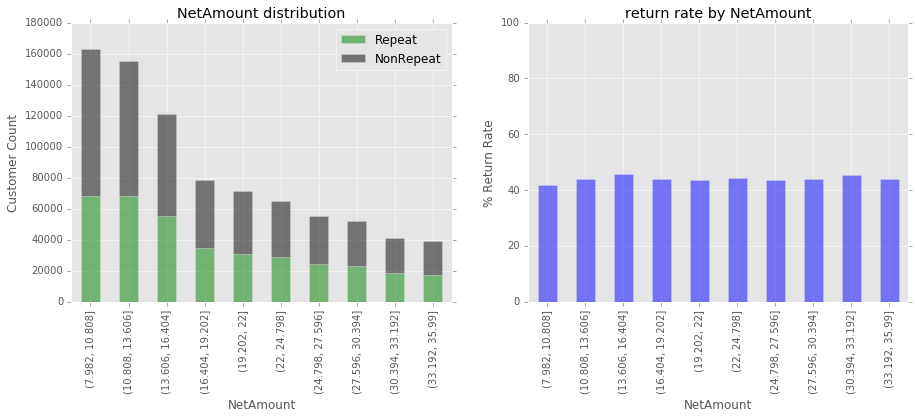

In [648]:
# frequency & probability for spenders between $0 and $250 (to account for outliers in sales)
plot_rrate_hist(df[(df['NetAmount']<36) & (df['NetAmount']>8)], 'NetAmount',10)

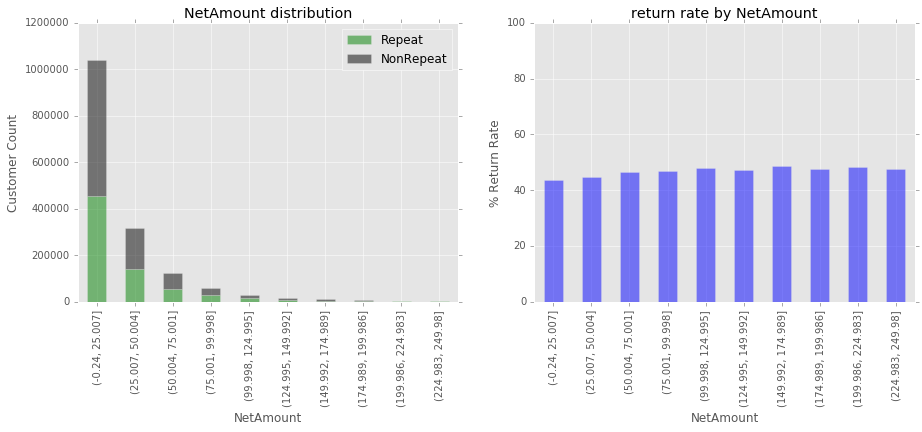

In [649]:
# frequency & probability for spenders between $0 and $250 (to account for outliers in sales)
plot_rrate_hist(df[(df['NetAmount']<250) & (df['NetAmount']>0)], 'NetAmount',10)

### inspecting into correlation of features
- as expected, some features have very high correlations
    - Sales Lines & Net Amount
    - Net Amount & Net Retail Amount
    - Sale Lines & Unique Items


- ML algorithm will have to accomodate highly-correlated features

In [650]:
# find correlations between 
Xcorr = X.corr()
Xcorr.where((Xcorr >.5) & (Xcorr < 1),'')

,TicketTime,PriorVisits,SaleLines,ReturnLines,GiftCardLines,NetAmount,NetRetailAmount,NetQSRAmount,DiscountAmount,UniqueItems,UniqueCategories,ReturnedBags,BoughtProduce,TicketMonthDecimal,WeekdayNumber,IsFrontEnd
TicketTime,,,,,,,,,,,,,,,,
PriorVisits,,,,,,,,,,,,,,,,
SaleLines,,,,,,0.772714,0.785757,,,0.980805,0.844837,,0.508431,,,
ReturnLines,,,,,,,,,,,,0.687726,,,,
GiftCardLines,,,,,,,,,,,,,,,,
NetAmount,,,0.772714,,,,0.96559,,,0.747154,0.646295,,,,,
NetRetailAmount,,,0.785757,,,0.96559,,,,0.7636,0.675023,,,,,
NetQSRAmount,,,,,,,,,,,,,,,,
DiscountAmount,,,,,,,,,,,,,,,,
UniqueItems,,,0.980805,,,0.747154,0.7636,,,,0.867877,,0.532414,,,


### split data into test/train sets

In [636]:
# separate the data set into features and prediction
X = df.drop('WillReturn',axis=1).copy()
y = df['WillReturn']

In [753]:
# split into test/train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.25, random_state=7)

### applying k-means clusters as a feature
- from preliminary analysis, k-means clusters seem well-defined and intuitive from a business perspective
- the goal of this project is to better understand and segment customers, so clustering is very important

In [756]:
km_drop_cols = ['TicketTime', 'GiftCardLines', 'NetAmount','DiscountAmount','TicketMonthDecimal', 'WeekdayNumber']
X_train_km = X_train.drop(km_drop_cols, axis=1).copy()
X_test_km = X_test.drop(km_drop_cols, axis=1).copy()

In [759]:
# scale features for k-means cluster
scale = StandardScaler()
scale.fit(X_train_km)
X_train_km_std = scale.transform(X_train_km)
X_test_km_std = scale.transform(X_test_km)

In [ ]:
# finding the elbow plotting inertia
k = []
i = []
for n in range(1,15):
    km2 = KMeans(n_clusters=n, n_jobs=-1, random_state=7)
    km2.fit(X_train_km)
    k.append(n)
    i.append(km2.inertia_)

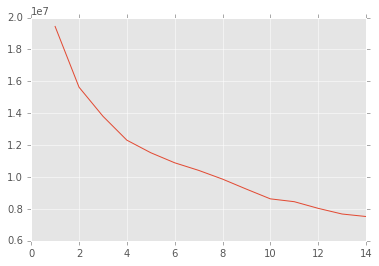

In [653]:
# plotting clusters vs inertia
plt.plot(k, i);

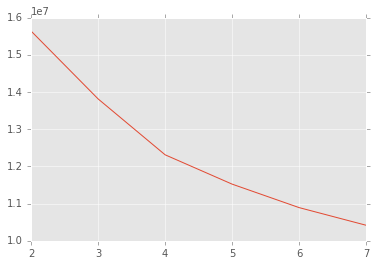

In [801]:
# plotting clusters vs inertia, zoomed in to see elbow at 4 clusters
plt.plot(k[1:7], i[1:7]);

In [763]:
# create kmeans with 4 clusters, get cluster labels
km = KMeans(n_clusters=4, n_init=20, n_jobs=-1, random_state=7)
km.fit(X_train_km_std)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=20,
    n_jobs=-1, precompute_distances='auto', random_state=7, tol=0.0001,
    verbose=0)

In [798]:
# get specific inertia
print('inertia:\t {:.2f}'.format(km.inertia_))

inertia:	 5585757.58


In [762]:
# show cluster centers
pd.set_option('display.float_format', lambda x: '%.3f' % x)
columns = {str(x): scale.inverse_transform(km.cluster_centers_[x]) for x in range(0,len(km.cluster_centers_))}
dfclus = pd.DataFrame(columns, index=X_train_km.columns).copy()
#dfclus.columns=['Sampler','Lunch Junkie','Regular','Pro']
dfclus

,0,1,2,3
PriorVisits,7.237,4.008,10.669,5.963
SaleLines,12.663,1.735,5.520,3.495
ReturnLines,0.008,0.002,1.085,0.009
NetRetailAmount,98.157,4.446,39.013,27.646
NetQSRAmount,2.142,9.055,0.707,0.636
UniqueItems,11.741,1.670,6.170,3.305
UniqueCategories,5.979,1.252,3.987,2.325
ReturnedBags,0.000,-0.000,0.964,-0.000
BoughtProduce,0.827,0.032,0.548,0.366
IsFrontEnd,0.989,0.006,0.987,0.986


In [797]:
# put k-means cluster labels on original dataset
dfkm_train = pd.DataFrame(data=km.predict(X_train_km_std), index=X_train.index, columns=['km_label'])
X_train_2 = pd.concat([X_train,dfkm_train], axis=1)

dfkm_test = pd.DataFrame(data=km.predict(X_test_km_std), index=X_test.index, columns=['km_label'])
X_test_2 = pd.concat([X_test, dfkm_test], axis=1)

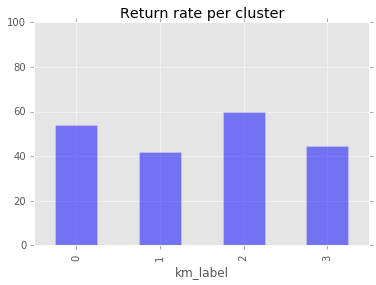

In [814]:
# return rate per cluster label
rrdf = (pd.concat([X_train_2, y_train], axis=1).groupby('km_label')['WillReturn'].mean() * 100)
rrdf.plot(kind='bar', ylim=(0,100), color='b', alpha=.5, title='Return rate per cluster');

### helper function for scoring models

In [839]:
def all_score(mod_nam, mod, X_test, y_test):
    '''Score model according to accuracy, recall, and f1 score
        and returns dataframe of scores'''
    y_pred = mod.predict(X_test)
    
    scores = {}
    scores['test_name'] = ['accuracy','precision','recall','f1']
    scores['test_score'] = []
    
    scores['test_score'].append(round(accuracy_score(y_test, y_pred) * 100, 2))
    scores['test_score'].append(round(precision_score(y_test, y_pred) * 100, 2))
    scores['test_score'].append(round(recall_score(y_test, y_pred) * 100, 2))
    scores['test_score'].append(round(f1_score(y_test, y_pred) * 100, 2))
    
    return pd.DataFrame(scores)

### applying random forest classifier for predictions
- random forest should perform well given:
    - correlated features
    - outliers
    - non-linear complexity

In [817]:
rf = RandomForestClassifier(n_estimators = 20, random_state = 7, n_jobs = -1)
rf.fit(X_train_2, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

In [843]:
all_score('RF', rf, X_test_2, y_test).sort_values('test_score', ascending=False)

,test_name,test_score
0,accuracy,71.380
1,precision,70.970
3,f1,65.020
2,recall,59.990


In [825]:
dfrf = pd.DataFrame({'Features':X_train_2.columns, 'Importance':rf.feature_importances_})
dfrf.sort_values('Importance', inplace=True, ascending=False)
#dfrf[dfrf['Importance']>=0.05]
dfrf

,Features,Importance
1,PriorVisits,0.238
0,TicketTime,0.209
13,TicketMonthDecimal,0.174
5,NetAmount,0.109
6,NetRetailAmount,0.088
14,WeekdayNumber,0.045
7,NetQSRAmount,0.037
2,SaleLines,0.026
9,UniqueItems,0.023
10,UniqueCategories,0.019
